In [108]:
#my addition
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier



import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import warnings
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.ensemble import VotingClassifier, BaggingClassifier, \
    AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier


from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

from IPython.display import Image
from sklearn.externals.six import StringIO
# from sklearn.model_selection import cross_val_


from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances

from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np
import webcolors
import squarify


![](downloads_schema.png)

In [2]:
#there is 14814 sets and 13603 in the data with parts. we can't combine them. 8.2% of data gone

df_inventory_parts = pd.read_csv('inventory_parts.csv').rename(columns={'quantity':'inventory_parts_quantity'})
df_colors = pd.read_csv('colors.csv').rename(columns={'name':'color_name','is_trans':'color_transpatent'})
df_complete = df_inventory_parts.merge(right=df_colors, how='left', left_on='color_id',right_on='id').drop(columns='id')
df_inventory_parts.nunique()
df_parts = pd.read_csv('parts.csv')
df_complete = df_complete.merge(right=df_parts, how='left', left_on='part_num',right_on='part_num').rename(columns={'name':'part_name'})
try_no_spare = df_complete[df_complete['is_spare']=='f']

df_part_categories = pd.read_csv('part_categories.csv')
df_complete = df_complete.merge(right=df_part_categories, how='left', left_on='part_cat_id',right_on='id').rename(columns={'name':'part_category_name'}).drop(columns='id')

df_inventories = pd.read_csv('inventories.csv')
df_complete = df_complete.merge(right=df_inventories, how='left', left_on='inventory_id',right_on='id').rename(columns={'version':'set_inventory_version'}).drop(columns='id')

df_sets = pd.read_csv('sets.csv')
df_complete = df_complete.merge(right=df_sets, how='left', left_on='set_num',right_on='set_num').rename(columns={'name':'set_name','theme_id':'set_theme_id','num_parts':'total_set_num_parts','year':'set_year'})

df_themes = pd.read_csv('themes.csv')
df_themes['parent_id'][df_themes['parent_id'].isnull()] = df_themes['id'][df_themes['parent_id'].isnull()]
df_complete = df_complete.merge(right=df_themes, how='left', left_on='set_theme_id',right_on='id').rename(columns={'name':'set_theme_name','parent_id':'main_theme_set_id'}).drop(columns='id')

#df in set level: create set level
df_set_level = df_complete[['inventory_id', 'set_inventory_version', 'set_num', 'set_name', 'set_year', 'set_theme_id', 'total_set_num_parts', 'set_theme_name', 'main_theme_set_id']].drop_duplicates()

#df in set level: add parts category
df_parts_pivot = pd.pivot_table(df_complete[df_complete['is_spare']=='f'], values='inventory_parts_quantity', index='set_num', columns='part_category_name', aggfunc=np.sum).fillna(0)


##df in set level: add main set name. yaron take this part~!!!!!!!!!##############
df_themes = pd.read_csv('themes.csv')
df_themes['parent_id'][df_themes['parent_id'].isnull()] = df_themes['id'][df_themes['parent_id'].isnull()]
x = df_themes.copy().drop(columns='parent_id').rename(columns={'name':'main_theme_set_name','id':'id2'})
df_themes = df_themes.merge(right=x, how='left', left_on='parent_id',right_on='id2').drop(columns=['id2','name']).rename(columns={'id':'id2'})
# df_themes['main_theme_set_name'] = df_themes['parent_id'].astype(str) + df_themes['main_theme_set_name']
df_set_level = df_set_level.merge(right=df_themes, how='left', left_on='set_theme_id',right_on='id2').drop(columns=['parent_id','id2'])



for i in df_parts_pivot.columns:
    df_parts_pivot.rename(columns={i: 'part_category:'+i}, inplace=True)
df_parts_pivot['total_parts_cheak'] = df_parts_pivot.sum(axis=1)
df_parts_pivot= df_parts_pivot.reset_index()

df_set_level = df_set_level.merge(right=df_parts_pivot, how='left', left_on='set_num',right_on='set_num').fillna(0)



#print(df_complete.info())
#https://rebrickable.com/api/v3/docs/?key=

C:\Users\yos\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yos\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
df_set_level.main_theme_set_name.nunique()
df_set_level.groupby('main_theme_set_name')['main_theme_set_name'].count().sort_values()

main_theme_set_name
Stranger Things                       1
World Racers                          1
Value Packs                           1
Universe                              1
Spider-Man                            2
Batman                                2
Avatar                                2
Ghostbusters                          2
The Powerpuff Girls                   2
Forma                                 4
The Hobbit and Lord of the Rings      4
LEGO Exclusive                        4
Spybiotics                            4
Inventor                              4
Fusion                                4
Dino Attack                           5
Primo                                 5
Disney's Mickey Mouse                 5
Dino 2010                             5
Scooby-Doo                            6
Angry Birds                           6
Ben 10                                6
Prince of Persia                      6
Discovery                             6
Disney              

<font size=5><span style=color:red>there are 141 diffrent parent themes but there are parent themes which relate to less than 5 observations
in order to handle the problem, we joined a few groups based on domain knowledge and created a group called 'Others'


In [4]:
df_set_level['main_theme_set_name'] = df_set_level['main_theme_set_name'].replace(['Spider-Man','Batman'],'Super Heroes')
df_set_level['main_theme_set_name'] = df_set_level['main_theme_set_name'].replace(['Dino Attack','Dino 2010','Dino'],'Dinosaurs')
df_set_level['main_theme_set_name'] = df_set_level['main_theme_set_name'].replace(['World Racers'],'Racers')
df_set_level['main_theme_set_name'] = df_set_level['main_theme_set_name'].replace(['The Hobbit and Lord of the Rings'],'The Lord of the Rings')
df_set_level['main_theme_set_name'] = df_set_level['main_theme_set_name'].replace(['Universe'],'Space')
df_set_level['main_theme_set_name'] = df_set_level['main_theme_set_name'].replace(["Disney's Mickey Mouse"],'Disney')
df_set_level['main_theme_set_name'] = df_set_level['main_theme_set_name'].replace(['Value Packs','Stranger Things','The Powerpuff Girls','Ghostbusters','Avatar','Fusion','Spybiotics','LEGO Exclusive','Inventor','Forma'],'other')
df_frequency = df_set_level.groupby('main_theme_set_name')['main_theme_set_name'].count().sort_values(ascending=False)
df_set_level.groupby('main_theme_set_name')['main_theme_set_name'].count().sort_values()

main_theme_set_name
Primo                         5
Scooby-Doo                    6
Prince of Persia              6
Angry Birds                   6
Ben 10                        6
Discovery                     6
Factory                       7
Vikings                       7
The Lone Ranger               8
Overwatch                     8
Hobby Sets                    9
Time Cruisers                 9
Pharaoh's Quest               9
Quatro                       10
DC Super Hero Girls          12
Disney                       12
Xtra                         13
Island Xtreme Stunts         13
Monster Fighters             14
Master Building Academy      14
SpongeBob SquarePants        14
Minitalia                    15
Rock Raiders                 15
4 Juniors                    15
The Lord of the Rings        16
Model Team                   17
Pirates of the Caribbean     18
Advent                       19
Znap                         19
Western                      20
                    

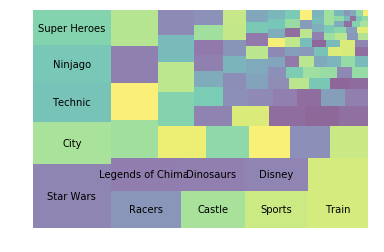

<Figure size 720x10800 with 0 Axes>

In [36]:
df_set_level['main_theme_set_name']
size = df_frequency.tolist()
squarify.plot(sizes=size, label=['Star Wars','City','Technic','Ninjago','Super Heroes','Racers','Castle','Sports','Train','Legends of Chima','Dinosaurs','Disney'],  alpha=.6 )
plt.axis('off')
plt.figure(figsize = (10,150))
plt.show()


In [113]:
rad.random()

0.15960695237830191

C:\Users\yos\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'main_theme_set_name' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


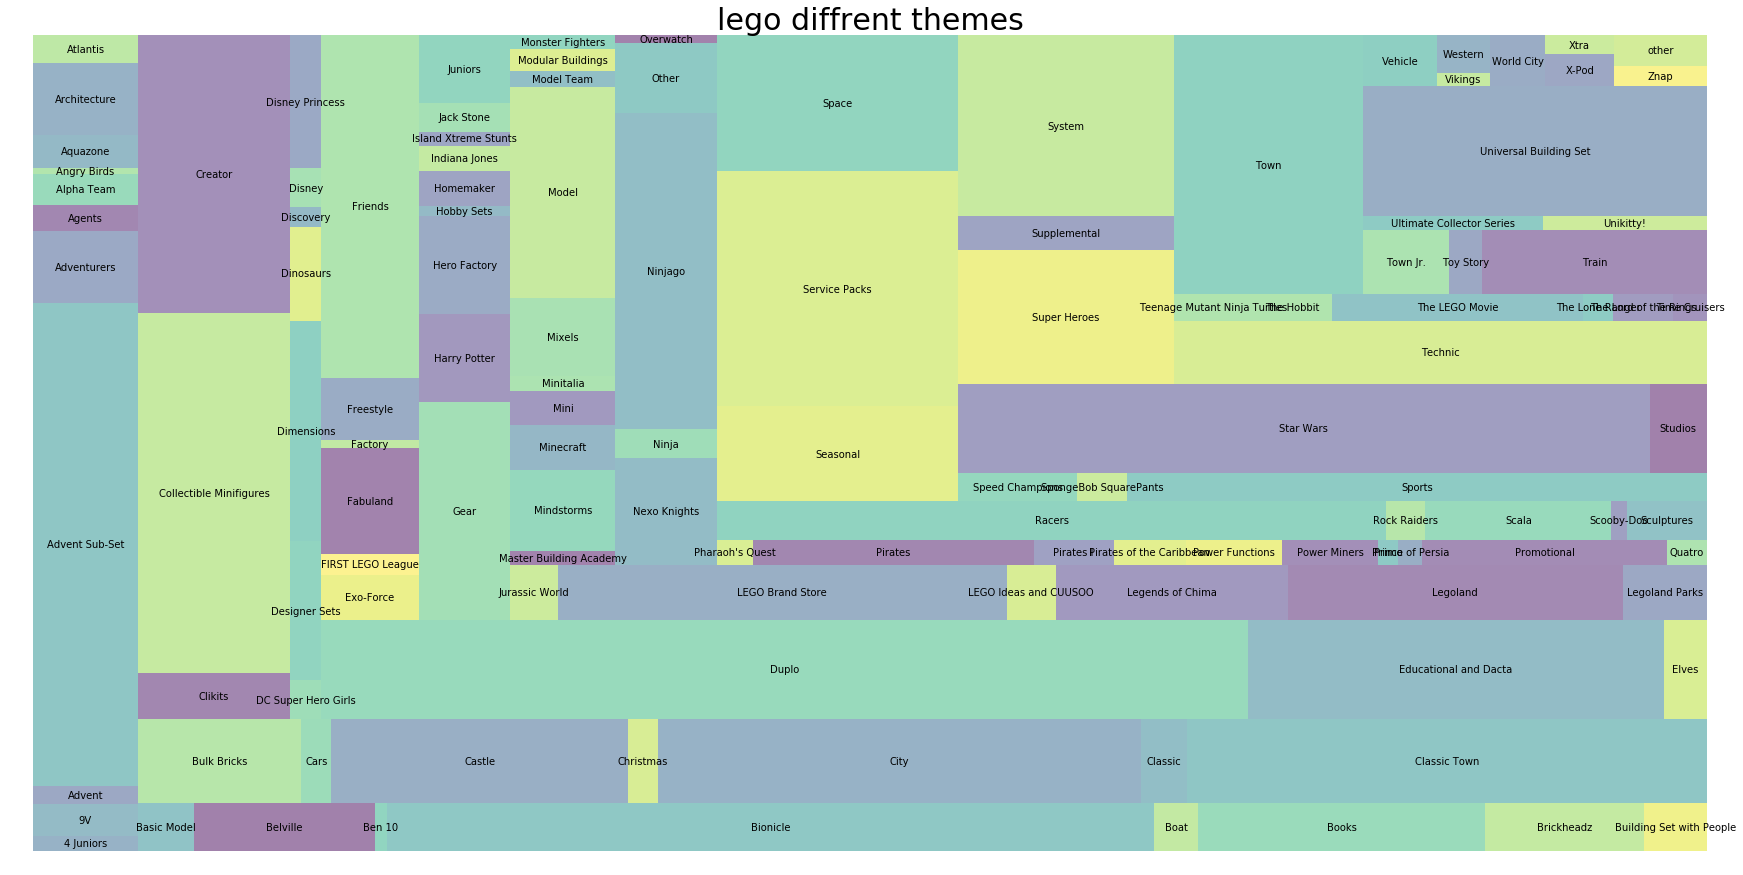

In [139]:

s = pd.DataFrame(df_set_level.groupby('main_theme_set_name')['main_theme_set_name'].count())
s.sort_values(by=['main_theme_set_name'])
plt.figure(figsize=(30,15))
plt.title('lego diffrent themes',fontsize=30)

squarify.plot(sizes=s['main_theme_set_name'], label=s.index, alpha=.5)
plt.axis('off')
plt.show()


In [ ]:
# libraries
#import matplotlib.pyplot as plt
#import squarify    # pip install squarify (algorithm for treemap)
 
# # If you have 2 lists
# squarify.plot(sizes=[13,22,35,5], label=["group A", "group B", "group C", "group D"], alpha=.7 )
# plt.axis('off')
# plt.show()
 
# If you have a data frame?
#import pandas as pd
#df = pd.DataFrame({'nb_people':[8,3,4,2], 'group':["group A", "group B", "group C", "group D"] })
squarify.plot(sizes=df['nb_people'], label=df['group'], alpha=.8 )
plt.axis('off')
plt.show()


<font size=5><span style=color:blue>feature engineering: create color variable

In [6]:
########how much the set is colorful############################
####there are sets with 1
#rgb in regular style from hex
def my_rgb(x):
    return list(webcolors.hex_to_rgb(f'#{x}'))

df_complete['rgb1'] = df_complete['rgb'].apply(lambda x:my_rgb(x))
df_complete[['r','g','b']] = pd.DataFrame(df_complete['rgb1'].values.tolist())

#create the proper df for color: multiply block per frame
df_no_spare = df_complete[df_complete['is_spare']=='f']
parts_num = df_no_spare['inventory_parts_quantity']
df_no_spare = pd.DataFrame(np.repeat(df_no_spare.values,parts_num,axis=0),columns=df_no_spare.columns)
df_no_spare['r'] = df_no_spare['r'].astype(float)
df_no_spare['g'] = df_no_spare['g'].astype(float)
df_no_spare['b'] = df_no_spare['b'].astype(float)

#set color by variance of auclidean distance rgb######
a = df_no_spare.groupby('set_num')[['r','g','b']].mean()
a = a.rename(columns={'r':'r_mean', 'g':'g_mean', 'b':'b_mean'})
df_no_spare = df_no_spare.merge(a, how='left', left_on='set_num', right_on='set_num')
df_no_spare['rgb_distance'] = np.sqrt((df_no_spare['r']-df_no_spare['r_mean'])**2+\
                              (df_no_spare['g']-df_no_spare['g_mean'])**2+\
                              (df_no_spare['b']-df_no_spare['b_mean'])**2)
a = pd.DataFrame(df_no_spare.groupby('set_num')['rgb_distance'].var())
df_set_level = df_set_level.merge(a, how='left', left_on='set_num', right_on='set_num')


feature engineering: main color

In [7]:
df_main_color = df_no_spare.groupby('set_num')['color_name'].apply(lambda x: x.value_counts().idxmax()).reset_index().rename(columns={'color_name':'main_color'})
df_set_level = df_set_level.merge(df_main_color, how='left', left_on='set_num', right_on='set_num')

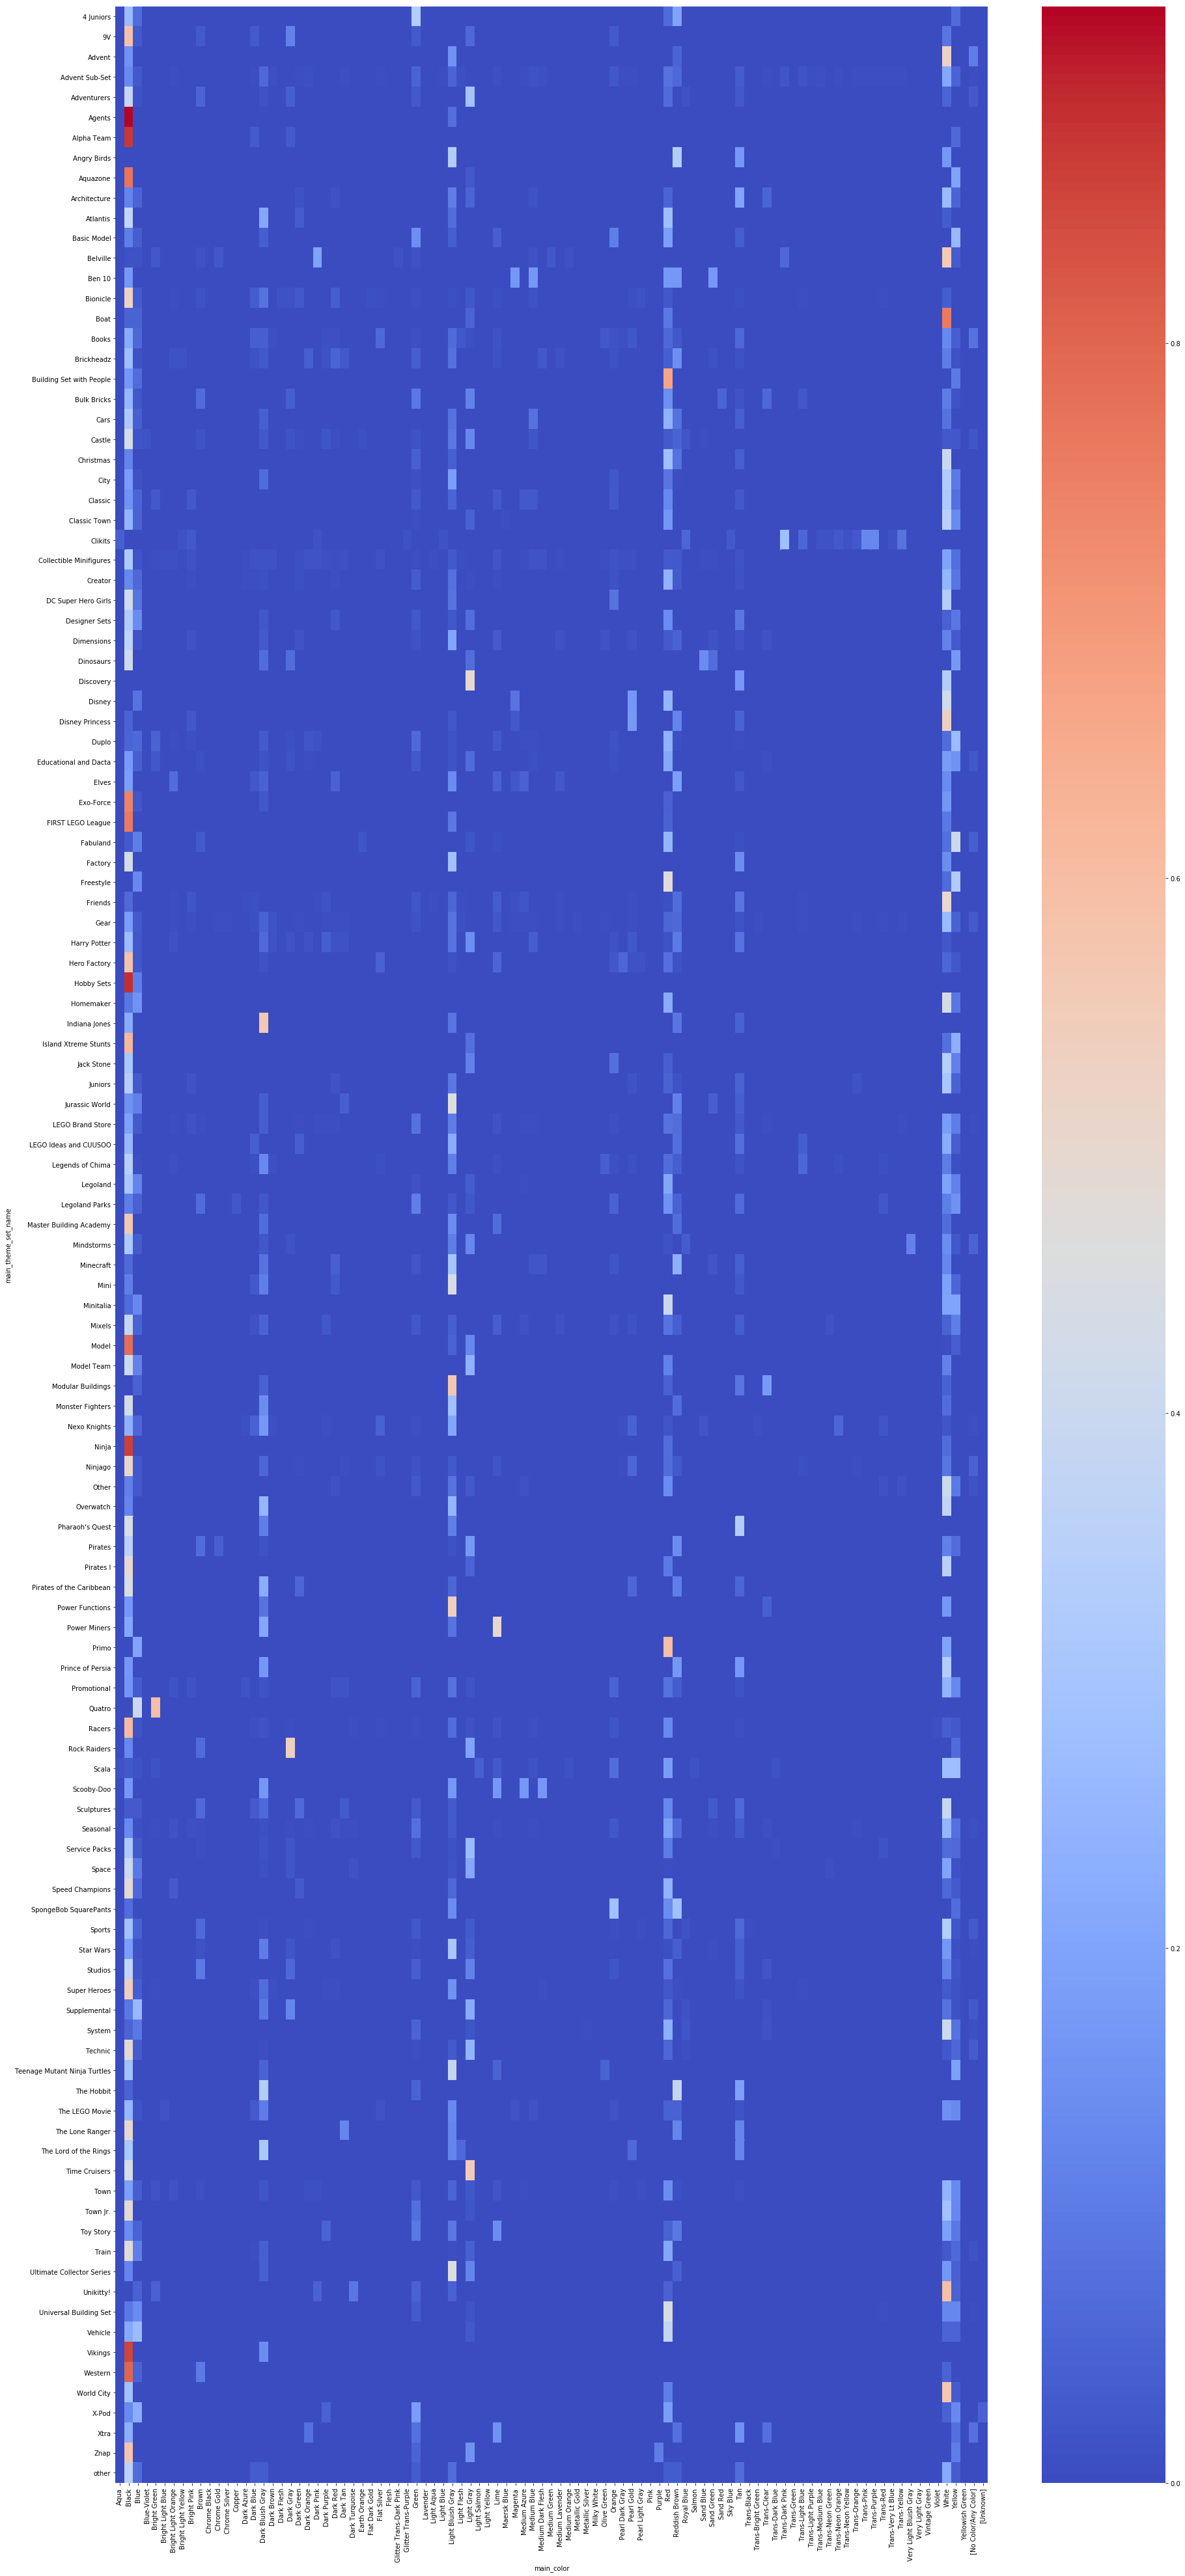

In [8]:
heat = pd.crosstab(columns=df_set_level['main_color'], 
                          index=df_set_level['main_theme_set_name'], 
                          normalize='index')
plt.figure(figsize = (30,70))
sns.heatmap(data=heat, cmap='coolwarm')

<font size=5><span style=color:red>
conclusion: 
we can see that the dominent color is black 
we can also see some corrletion for instance:
'red' is the dominant color for 'World Racing'
'white' is the dominant color for 'Universe'
    
<font size=5><span style=color:green>
mission for further explore - sort by color and re-show the color map horizontal


<font size=5><span style=color:blue>
feature engineering: set complicated or how many diffrent categories of parts in the set

In [9]:
#how many categories in the set
df_parts_pivot = pd.pivot_table(df_complete[df_complete['is_spare']=='f'], values='inventory_parts_quantity', index='set_num', columns='part_category_name', aggfunc=np.sum).fillna(0)
df_parts_pivot['total_parts_categories'] = np.count_nonzero(df_parts_pivot,axis=1)
df_parts_pivot= df_parts_pivot['total_parts_categories'].reset_index()
df_set_level = df_set_level.merge(df_parts_pivot, how='left', left_on='set_num', right_on='set_num')


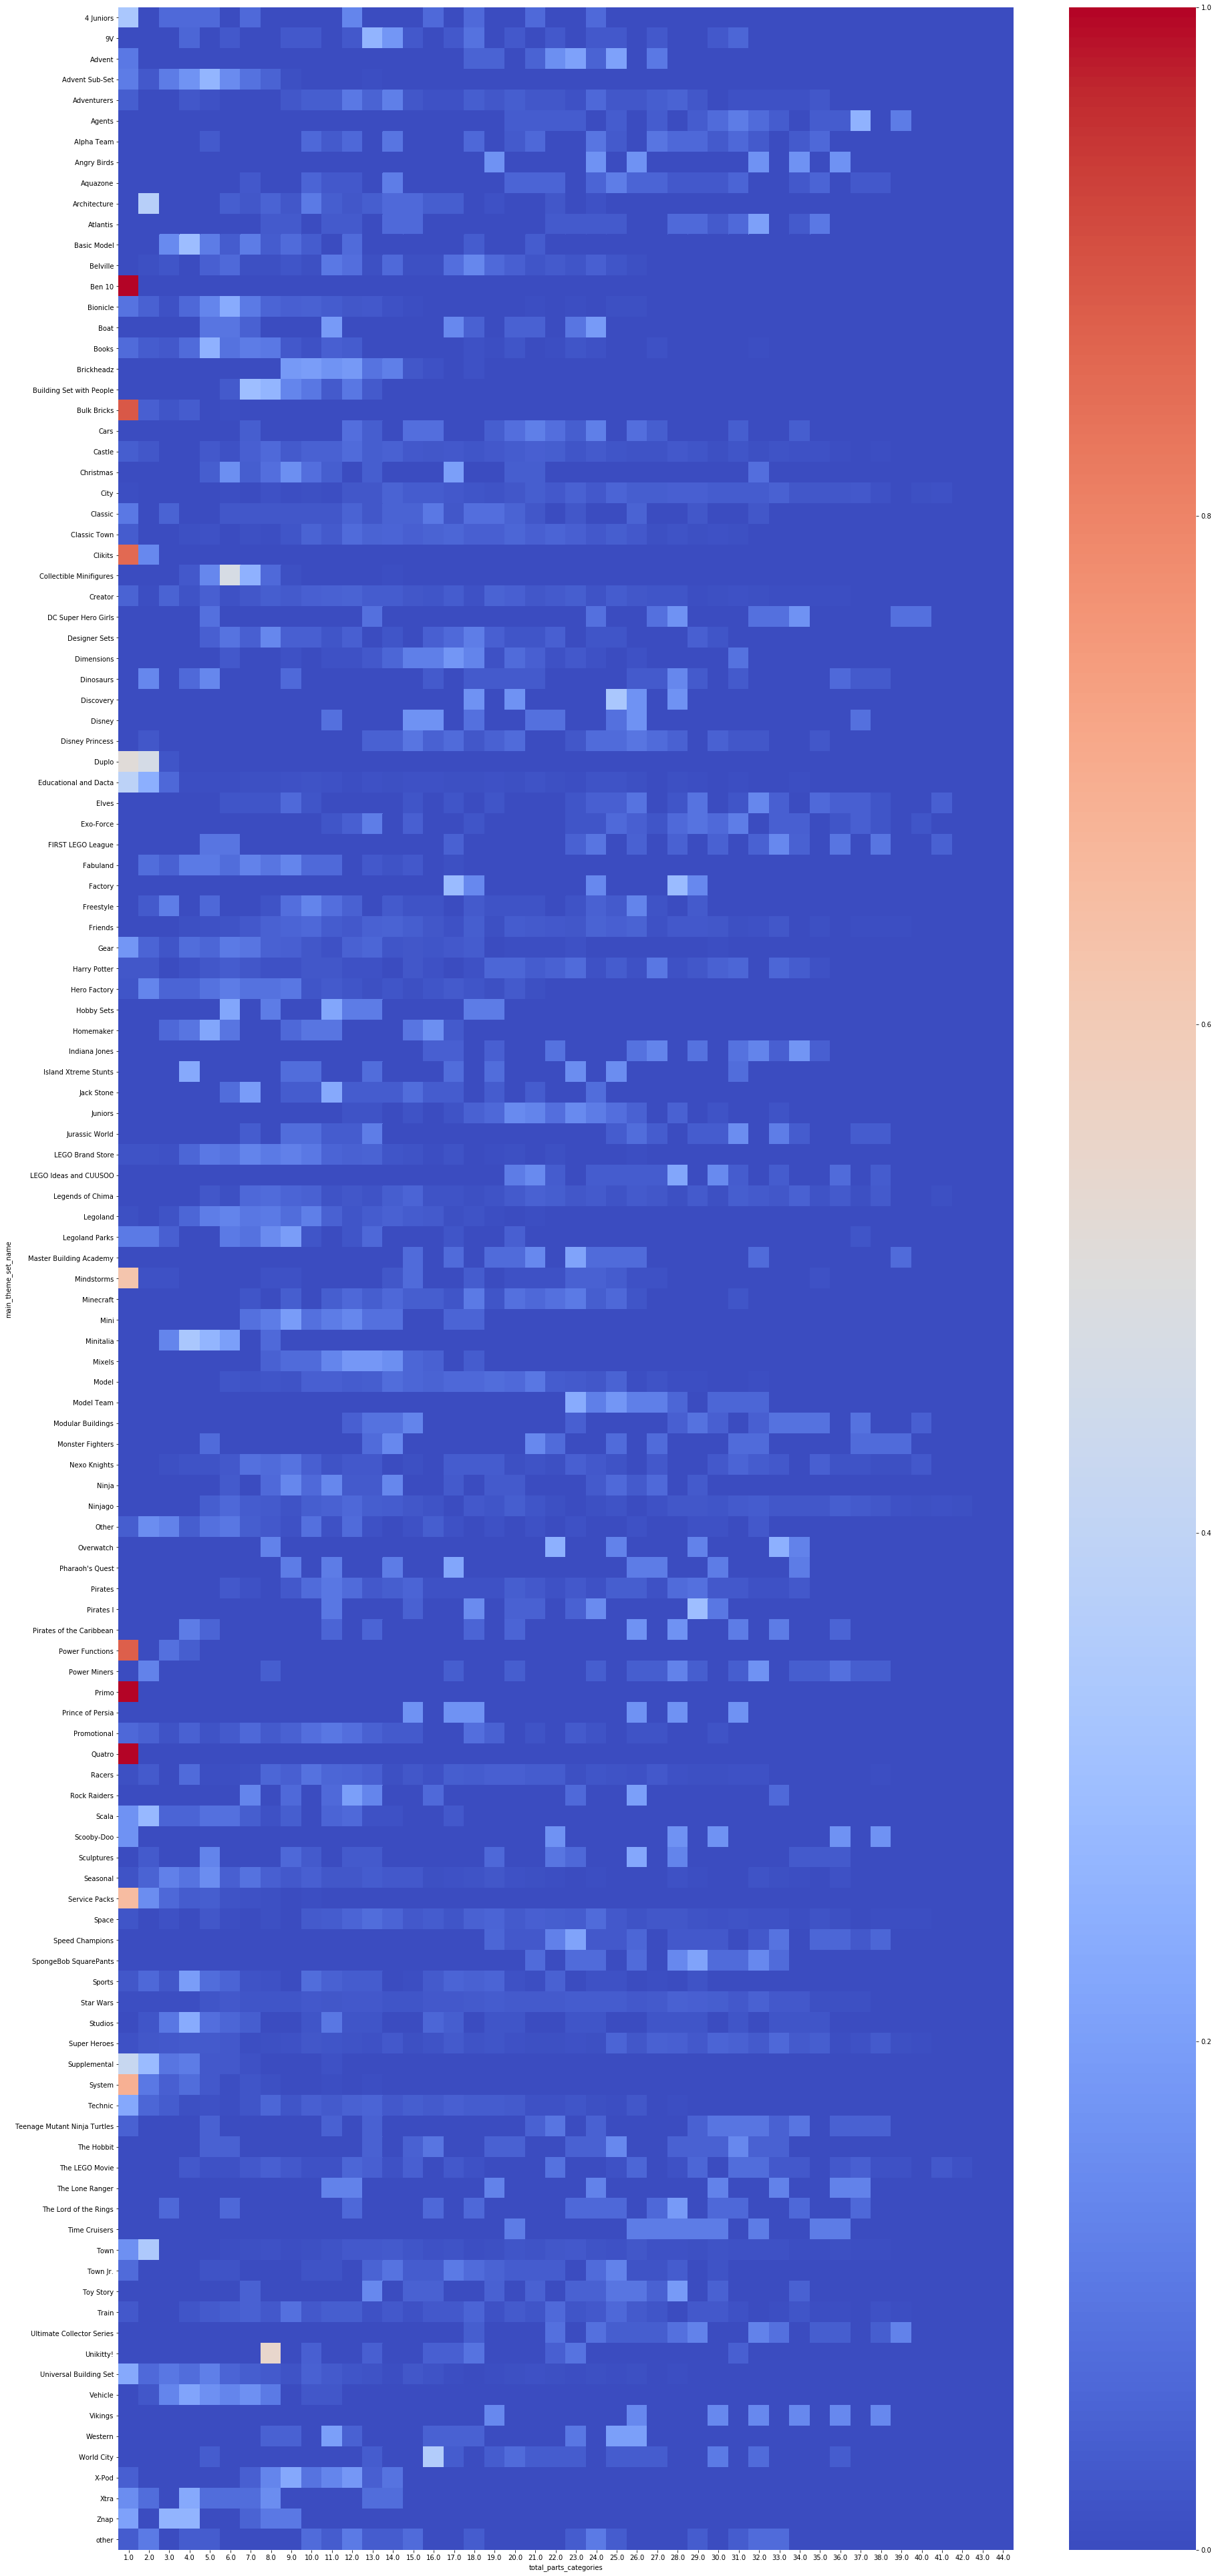

In [10]:
heat = pd.crosstab(columns=df_set_level['total_parts_categories'], 
                          index=df_set_level['main_theme_set_name'], 
                          normalize='index')
plt.figure(figsize = (30,70))
sns.heatmap(data=heat, cmap='coolwarm')

<font size=5><span style=color:red>
conclusion: we can clearly see that there is a correlation in some themes (some themes are around a certain range of part category)

<font size=5><span style=color:blue>
outliers-fast

In [11]:
df_set_level['rgb_distance'].fillna(0,inplace=True)
df_set_level['total_parts_categories'].fillna(1,inplace=True)
#df_set_level[df_set_level['total_parts_categories'].isnull()]

<font size=5><span style=color:red>
define X and y
get dummies for the main color

In [12]:
X = df_set_level.drop(columns= ['inventory_id', 'set_num','set_inventory_version','set_name','set_theme_id','set_theme_name','main_theme_set_id','main_theme_set_name'])
X = pd.get_dummies(X,drop_first=False)
y = df_set_level['main_theme_set_name']
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size =0.75, random_state =0)

C:\Users\yos\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [22]:
params = {'min_samples_leaf': range(5,20),'random_state':[0]}
mdt_grid = GridSearchCV(DecisionTreeClassifier(),params,cv=10).fit(X_train,y_train)

# mdt = DecisionTreeClassifier(max_depth=4,random_state=0).fit(X_train,y_train)

y_train_pred = mdt_grid.predict(X_train)
y_test_pred = mdt_grid.predict(X_test)

print(mdt_grid.best_params_)
#print(mdt_grid.best_score_)
print('train accuracy score:',mdt_grid.best_estimator_.score(X_train,y_train))
print('test accuracy score:',mdt_grid.best_estimator_.score(X_test,y_test))

C:\Users\yos\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\yos\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'min_samples_leaf': 5, 'random_state': 0}
train accuracy score: 0.7618347544839753
test accuracy score: 0.5777712437518377


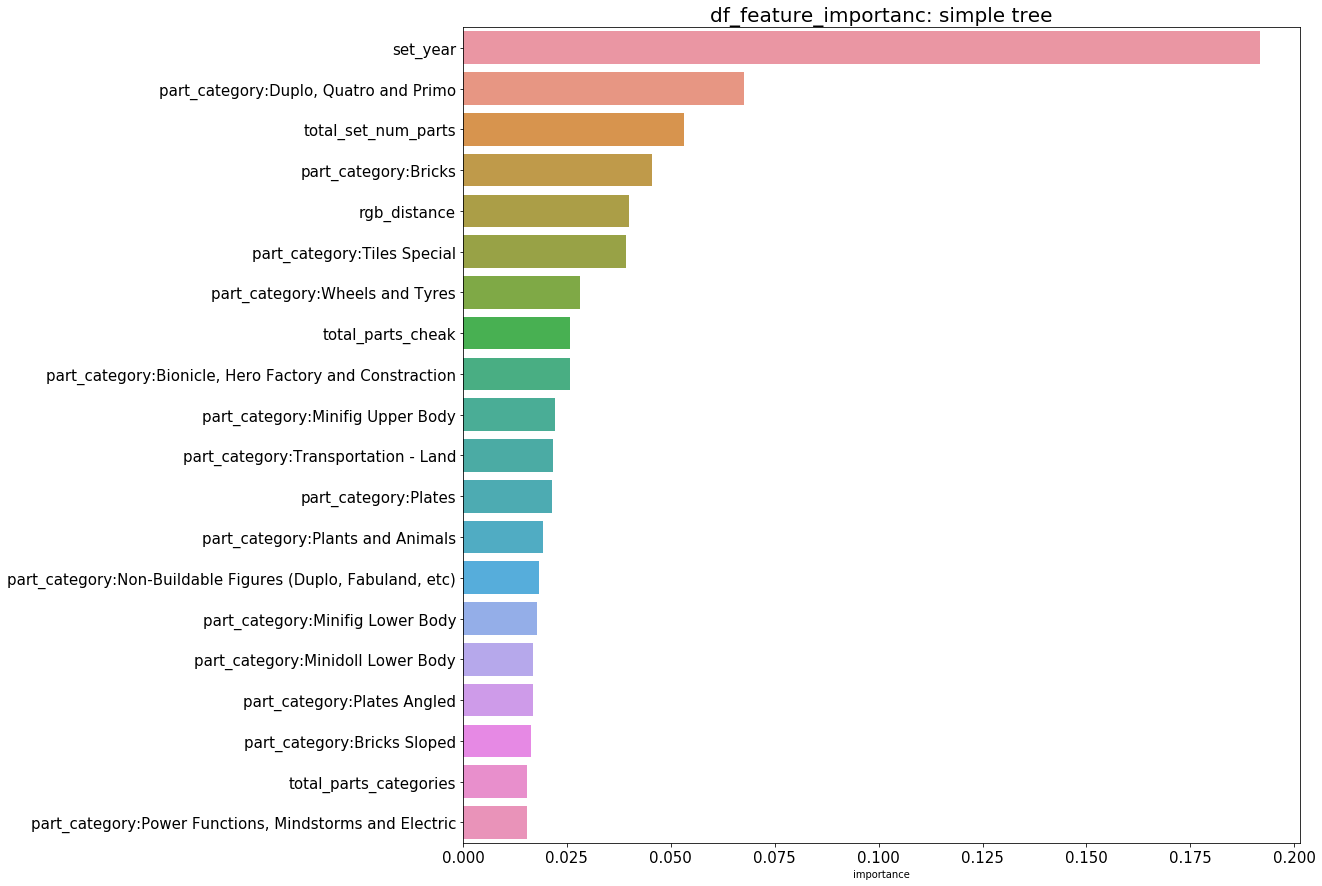

In [57]:
df_feature_importanc = pd.DataFrame(mdt_grid.best_estimator_.feature_importances_,index=X.columns).rename(columns={0:'importance'})
#df_feature_importanc.sort_values(by='importance',ascending=False)
df_feature_importanc = df_feature_importanc.sort_values(by='importance',ascending=False).head(20)
#sns.barplot(data=df_feature_importanc,X=df_feature_importanc.index,y='importance')
#df_feature_importanc
#df_feature_importanc['importance'].tolist()
plt.figure(figsize=(15,15))
plt.title('df_feature_importanc: simple tree',fontsize=20,)
ax = sns.barplot(y=df_feature_importanc.index, x="importance", data=df_feature_importanc).tick_params(labelsize=15)

<font size=5><span style=color:red>simple tree: 58% on test accuarcy! not bad for start<br>
    rgb color feature is the 8 feature in importance<BR>

<font size=5><span style=color:blue>simple tree: feature reducation</span>

In [15]:
X_fr = df_set_level.drop(columns= ['inventory_id', 'set_num','set_inventory_version','set_name','set_theme_id','set_theme_name','main_theme_set_id','main_theme_set_name'])
X_fr = pd.get_dummies(X,drop_first=False)

selector = VarianceThreshold(0.15).fit(X_fr)
X_selected = selector.transform(X_fr)


X_selected = pd.DataFrame(X_selected,columns=X.columns[selector.get_support()])
X_selected.head(2)

X_train_selec,X_test_selec,y_train,y_test = train_test_split(X_selected,y,train_size =0.75, random_state =0)

params = {'min_samples_leaf': range(15,20),'random_state':[0]}
mdt_grid = GridSearchCV(DecisionTreeClassifier(),params,cv=10).fit(X_train_selec,y_train)

# mdt = DecisionTreeClassifier(max_depth=4,random_state=0).fit(X_train,y_train)

y_train_pred = mdt_grid.predict(X_train_selec)
y_test_pred = mdt_grid.predict(X_test_selec)

print(mdt_grid.best_params_)
#print(mdt_grid.best_score_)
print('train accuracy score:',mdt_grid.best_estimator_.score(X_train_selec,y_train))
print('test accuracy score:',mdt_grid.best_estimator_.score(X_test_selec,y_test))

C:\Users\yos\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\yos\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\yos\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'min_samples_leaf': 15, 'random_state': 0}
train accuracy score: 0.6348132902087621
test accuracy score: 0.5501323140252867


<font size=5><span style=color:red>conclusion: dimenson reduction isn't better then all dimensons

<font size=5><span style=color:blue>simple tree: pca

In [16]:
compo = []
train_pca_st = []
test_pca_st = []
train_pca_min = []
test_pca_min = []
for i in range(2,70):
#PCA-StandardScaler
    scalar = StandardScaler().fit(X_train)
    X_train_scalar_st = scalar.transform(X_train)
    X_test_scalar_st = scalar.transform(X_test)
    
    pca_transform = PCA(n_components=i).fit(X_train_scalar_st)
    X_train_pca_st = pca_transform.transform(X_train_scalar_st)
    X_test_pca_st = pca_transform.transform(X_test_scalar_st)
    
    params = {'min_samples_leaf': [15],'random_state':[0]}
    mdt_grid = GridSearchCV(DecisionTreeClassifier(),params,cv=10).fit(X_train_pca_st,y_train)

    mdt = DecisionTreeClassifier(min_samples_leaf=15,random_state=0).fit(X_train_pca_st,y_train)

    y_train_pred = mdt_grid.predict(X_train_pca_st)
    y_test_pred = mdt_grid.predict(X_test_pca_st)

#     print('PCA-stan',mdt_grid.best_params_)
    #print(mdt_grid.best_score_)
#     print('PCA-stan: train accuracy score:',mdt_grid.best_estimator_.score(X_train_pca_st,y_train))
#     print('PCA-stan: test accuracy score:',mdt_grid.best_estimator_.score(X_test_pca_st,y_test))
    compo.append(i)
    train_pca_st.append(mdt_grid.best_estimator_.score(X_train_pca_st,y_train))
    test_pca_st.append(mdt_grid.best_estimator_.score(X_test_pca_st,y_test))

# #PCA-MiN

    scalar = MinMaxScaler().fit(X_train)
    X_train_scalar1 = scalar.transform(X_train)
    X_test_scalar1 = scalar.transform(X_test)

    pca_transform = PCA(n_components=i).fit(X_train_scalar1)
    X_train_pca_min = pca_transform.transform(X_train_scalar1)
    X_test_pca_min = pca_transform.transform(X_test_scalar1)
    
    params = {'min_samples_leaf': [15],'random_state':[0]}
    mdt_grid = GridSearchCV(DecisionTreeClassifier(),params,cv=10).fit(X_train_pca_min,y_train)

    mdt = DecisionTreeClassifier(min_samples_leaf=15,random_state=0).fit(X_train_pca_min,y_train)

    y_train_pred = mdt_grid.predict(X_train_pca_min)
    y_test_pred = mdt_grid.predict(X_test_pca_min)

#     print('PCA-min',mdt_grid.best_params_)
    #print(mdt_grid.best_score_)
#     print('PCA-min: train accuracy score:',mdt_grid.best_estimator_.score(X_train_pca_min,y_train))
#     print('PCA-min: test accuracy score:',mdt_grid.best_estimator_.score(X_test_pca_min,y_test))
    train_pca_min.append(mdt_grid.best_estimator_.score(X_train_pca_min,y_train))
    test_pca_min.append(mdt_grid.best_estimator_.score(X_test_pca_min,y_test))


C:\Users\yos\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\yos\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
C:\Users\yos\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\yos\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\yos\Anaconda3\lib\site-packages\sklearn\mo

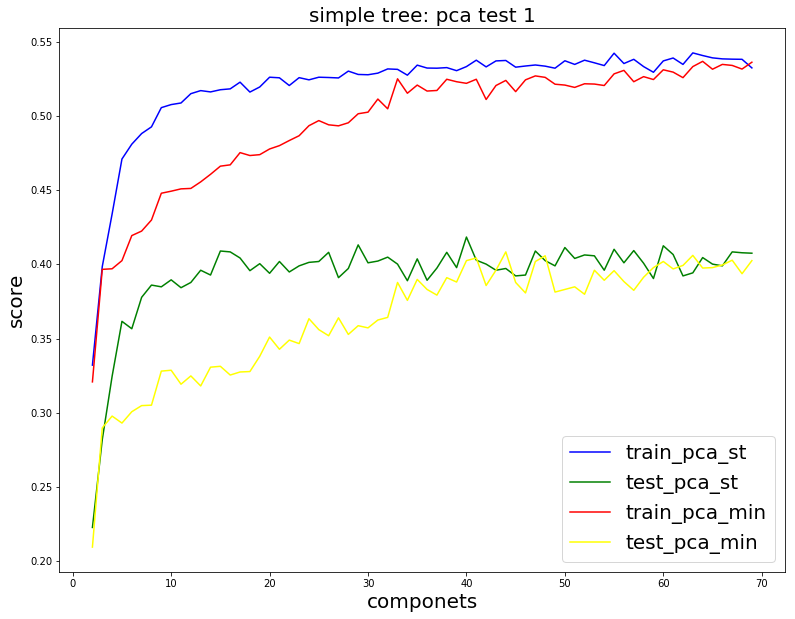

In [17]:
df_pca = pd.DataFrame({'componets':compo,
                       'train_pca_st':train_pca_st,
                       'test_pca_st':test_pca_st,
                      'train_pca_min':train_pca_min,
                      'test_pca_min':test_pca_min,})
#plt.ylabel('Damped oscillation')
plt.figure(figsize=(13,10))
plt.title('simple tree: pca test 1',fontsize=20)
plt.xlabel('componets',fontsize=20)
plt.ylabel('score',fontsize=20)
plt.plot('componets','train_pca_st',data=df_pca,color='blue')
plt.plot('componets','test_pca_st',data=df_pca,color='green')
plt.plot('componets','train_pca_min',data=df_pca,color='red')
plt.plot('componets','test_pca_min',data=df_pca,color='yellow')
plt.legend(prop={'size': 20})

<font size=5><span style=color:red>
conclusion: pca isn't better then all dimensons (very bad test score)



In [546]:
dot_data = StringIO()  
export_graphviz(decision_tree=mdt_grid,
                out_file=dot_data,
                feature_names=X.columns,
                class_names=mdt_grid.classes_,
                leaves_parallel=True,
                impurity=False,
                filled=True,
                rotate=False,
                rounded=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=900) 

<font size=5><span style=color:blue>
bagging (boostrap-random forest)

In [115]:
#grid search
params = {'min_samples_leaf':np.linspace(10,15,1,dtype='int'),'n_estimators': [100],'max_features': np.linspace(10,80,10,dtype='int'),'random_state':[0]}
rfm = RandomForestClassifier()
rfm_grid = GridSearchCV(rfm,params,n_jobs=2 ,cv=2).fit(X_train,y_train)

print(rfm_grid.best_params_)
print(rfm_grid.best_score_)
print('train accuracy score:',rfm_grid.best_estimator_.score(X_train,y_train))
print('test accuracy score:',rfm_grid.best_estimator_.score(X_test,y_test))

# dtm = DecisionTreeClassifier(min_samples_leaf=10)
# dtm_bag = BaggingClassifier(base_estimator=dtm,n_estimators=100).fit(X_train,y_train)

{'max_features': 64, 'min_samples_leaf': 10, 'n_estimators': 100, 'random_state': 0}
0.587474272272861
train accuracy score: 0.7484073311771048
test accuracy score: 0.6453984122316966


<font size=5><span style=color:red>64.53% accuarcy to random forest! (all features)

<font size=5><span style=color:blue>bagging (boostrap-random forest): dimenson reduction

In [116]:
#grid search
#params = {'min_samples_leaf':np.linspace(10,15,1,dtype='int'),'n_estimators': np.linspace(100,200,20,dtype='int'),'max_features': np.linspace(10,80,10,dtype='int'),'random_state':[0]}
#rfm_grid = GridSearchCV(rfm,params,n_jobs=-1,cv=5).fit(X_train_selec,y_train)
#rfm = RandomForestClassifier(min_samples_leaf=10,max_features=20,random_state=0).fit(X_train_selec,y_train)
for i in range(5,61,4):
    rfm = RandomForestClassifier(min_samples_leaf=10,max_features=i,random_state=0,n_estimators=50).fit(X_train_selec,y_train)
    #rfm = RandomForestClassifier(max_depth=3,max_features=30,random_state=0,n_estimators=200).fit(X_train_selec,y_train)

    #print(rfm_grid.best_params_)
    #print(rfm_grid.best_score_)
    print (i)
    print('train accuracy score:',rfm.score(X_train_selec,y_train))
    print('test accuracy score:',rfm.score(X_test_selec,y_test))

# dtm = DecisionTreeClassifier(min_samples_leaf=10)
# dtm_bag = BaggingClassifier(base_estimator=dtm,n_estimators=100).fit(X_train,y_train)

5
train accuracy score: 0.6632363030481231
test accuracy score: 0.5833578359306086
9
train accuracy score: 0.7000882093501911
test accuracy score: 0.6033519553072626
13
train accuracy score: 0.7197882975595413
test accuracy score: 0.6254042928550426
17
train accuracy score: 0.7327256689209056
test accuracy score: 0.6336371655395472
21
train accuracy score: 0.740468489659904
test accuracy score: 0.6336371655395472
25
train accuracy score: 0.7436048221111438
test accuracy score: 0.6430461628932667
29
train accuracy score: 0.7423306870528276
test accuracy score: 0.6430461628932667
33
train accuracy score: 0.7467411545623837
test accuracy score: 0.6418700382240518
37
train accuracy score: 0.747329216896991
test accuracy score: 0.6403998823875331
41
train accuracy score: 0.7469371753405861
test accuracy score: 0.6406939135548368
45
train accuracy score: 0.7408605312163089
test accuracy score: 0.6359894148779771
49
train accuracy score: 0.7422326766637264
test accuracy score: 0.6324610408703

<font size=5><span style=color:red>conclusion: it appears that bagging can improve to 64.3% accuarcy with trees arount the size of 25-35 features

<font size=5><span style=color:blue> bagging (boostrap-random forest): PCA (st_div)

In [118]:
compo = []
df_train_pca_st = []
df_test_pca_st = []

for i in range(5,30,5):
#PCA-StandardScaler

    pca_transform = PCA(n_components=i).fit(X_train_scalar_st)
    X_train_pca_st = pca_transform.transform(X_train_scalar_st)
    X_test_pca_st = pca_transform.transform(X_test_scalar_st)

    rfm = RandomForestClassifier(min_samples_leaf=10,max_features=i,random_state=0,n_estimators=200).fit(X_train_pca_st,y_train)
    print (i)
#     print('rf-pca train accuracy score:',rfm.score(X_train_pca_st,y_train))
#     print('rf-pca test accuracy score:',rfm.score(X_test_pca_st,y_test))
    compo.append(i)
    df_train_pca_st.append(rfm.score(X_train_pca_st,y_train))
    df_test_pca_st.append(rfm.score(X_test_pca_st,y_test))

5
10
15
20
25


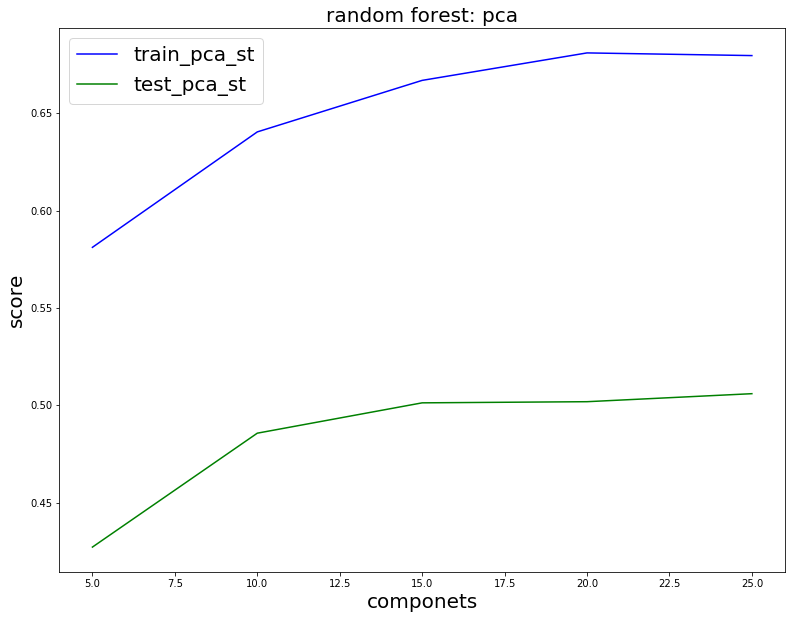

In [ ]:
df_pca = pd.DataFrame({'compo':compo,
                        'train_pca_st':df_train_pca_st,
                        'test_pca_st':df_test_pca_st})
#plt.ylabel('Damped oscillation')
plt.figure(figsize=(13,10))
plt.title('random forest: pca',fontsize=20)
plt.xlabel('componets',fontsize=20)
plt.ylabel('score',fontsize=20)
plt.plot('compo','train_pca_st',data=df_pca,color='blue')
plt.plot('compo','test_pca_st',data=df_pca,color='green')
#plt.plot('componets','train_pca_min',data=df_pca,color='red')
#plt.plot('componets','test_pca_min',data=df_pca,color='yellow')
plt.legend(prop={'size': 20})

<font size=5><span style=color:red>conlusion: random forest- we won't do pca and dimenson reduction<br> we reach 64.89% accuarcy to random forest! (all features)

<font size=5><span style=color:blue>Gradient boosting

In [ ]:
dt_boost = GradientBoostingClassifier(learning_rate=0.01,n_estimators=50,random_state=0,min_samples_leaf=5).fit(X_train,y_train)

#grid ready if i want to make a grid
# params = {'learning_rate':np.linspace(0.1,1,0.2,dtype='int'),'n_estimators':[100,150,200],'random_state':[0],'min_samples_leaf':[15]}
# dt_boost = GradientBoostingClassifier()
# dt_boost_grid = GridSearchCV(dt_boost,params).fit(X_train,y_train)

In [ ]:
print(dt_boost.score(X_train,y_train))
print(dt_boost.score(X_test,y_test))

# print(dt_boost_grid.best_params_)
# print('train accuracy score:',dt_boost_grid.best_estimator_.score(X_train,y_train))
# print('test accuracy score:',dt_boost_grid.best_estimator_.score(X_test,y_test))


<font size=5><span style=color:red>conclusion: gradient boosting isn't a good model for us + it took a long time to run it

<font size=5><span style=color:blue> SVM

In [ ]:
params = {'C':np.linspace(0.1,1,10)}
svm = SVC()
svm_grid = GridSearchCV(svm,params,cv=10).fit(X_train,y_train)

In [ ]:
print(svm_grid.score(X_train,y_train))
print(svm_grid.score(X_test,y_test))

print(svm_grid.best_params_)
print(svm_grid.best_score_)
print('train accuracy score:',svm_grid.best_estimator_.score(X_train,y_train))
print('test accuracy score:',svm_grid.best_estimator_.score(X_test,y_test))



<font size=5><span style=color:blue>KNN</span>

In [ ]:
#knnm = KNeighborsClassifier(n_neighbors=10).fit(X_train,y_train)
knnm = KNeighborsClassifier()
params = {'n_neighbors':range(5,11),'metric':['euclidean','minkowski','manhattan'],'n_jobs':[2]}
knn_grid = GridSearchCV(knnm,params,cv=5).fit(X_train,y_train)
print(knn_grid.best_params_)
print(knn_grid.best_score_)
print('knn_grid train accuracy score:',knn_grid.best_estimator_.score(X_train,y_train))
print('knn_grid test accuracy score:',knn_grid.best_estimator_.score(X_test,y_test))


<font size=5><span style=color:blue> KNN: PCS-ST

In [768]:

compo = []
df_train_pca_st = []
df_test_pca_st = []
df_params_pca_st = []
for i in range(5,51,5):
    pca_transform = PCA(n_components=i).fit(X_train_scalar_st)
    X_train_pca_st = pca_transform.transform(X_train_scalar_st)
    X_test_pca_st = pca_transform.transform(X_test_scalar_st)

    knnm = KNeighborsClassifier()
    params = {'n_neighbors':range(5,11),'metric':['euclidean','minkowski','manhattan'],'n_jobs':[-1]}
    knn_grid = GridSearchCV(knnm,params,cv=5).fit(X_train_pca_st,y_train)
#     print(knn_grid.best_params_)
#     print(knn_grid.best_score_)
#     print('knn_grid train accuracy score:',knn_grid.best_estimator_.score(X_train_pca_st,y_train))
#     print('knn_grid test accuracy score:',knn_grid.best_estimator_.score(X_test_pca_st,y_test))
    compo.append(i)
    df_train_pca_st.append(knn_grid.best_estimator_.score(X_train_pca_st,y_train))
    df_test_pca_st.append(knn_grid.best_estimator_.score(X_test_pca_st,y_test))
    df_params_pca_st.append(knn_grid.best_params_)

C:\Users\yos\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\yos\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\yos\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\yos\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change 

[{'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 7}, {'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 7}, {'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 6}, {'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 5}, {'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 7}, {'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 6}, {'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 5}, {'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 5}, {'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 5}, {'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 5}]


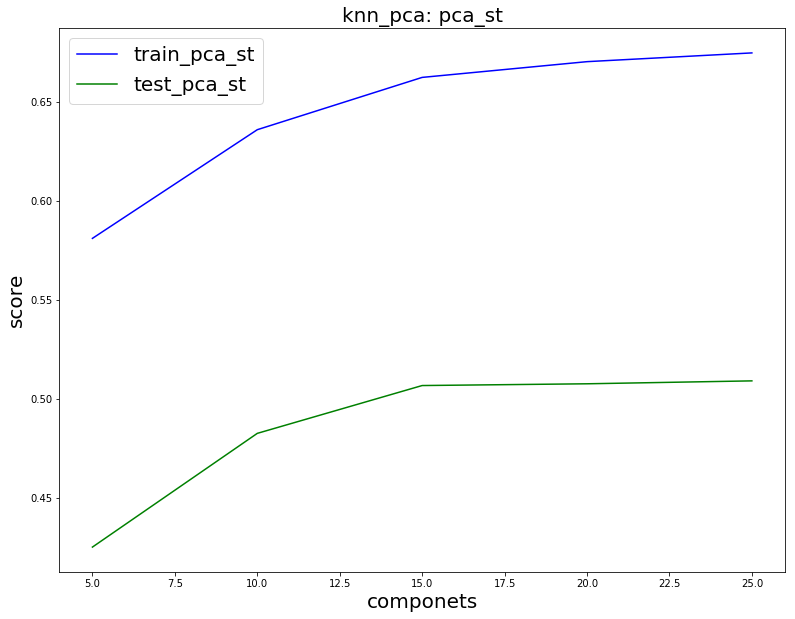

In [777]:
df_knn_pca = pd.DataFrame({'compo':compo,
                        'train_pca_st':df_train_pca_st,
                        'test_pca_st':df_test_pca_st})
#plt.ylabel('Damped oscillation')
plt.figure(figsize=(13,10))
plt.title('knn_pca: pca_st',fontsize=20)
plt.xlabel('componets',fontsize=20)
plt.ylabel('score',fontsize=20)
plt.plot('compo','train_pca_st',data=df_pca,color='blue')
plt.plot('compo','test_pca_st',data=df_pca,color='green')
#plt.plot('componets','train_pca_min',data=df_pca,color='red')
#plt.plot('componets','test_pca_min',data=df_pca,color='yellow')
plt.legend(prop={'size': 20})

<font size=5><span style=color:red>conclusion: KNN isn't a good model for this case

<font size=5><span style=color:blue> KNN: dimenson reduction

In [772]:
#knnm = KNeighborsClassifier(n_neighbors=10).fit(X_train,y_train)
knnm = KNeighborsClassifier()
params = {'n_neighbors':range(5,11),'metric':['euclidean','minkowski','manhattan'],'n_jobs':[2]}
knn_grid = GridSearchCV(knnm,params,cv=5).fit(X_train_selec,y_train)
print(knn_grid.best_params_)
print(knn_grid.best_score_)
print('knn_grid train accuracy score:',knn_grid.best_estimator_.score(X_train_selec,y_train))
print('knn_grid test accuracy score:',knn_grid.best_estimator_.score(X_test_selec,y_test))


C:\Users\yos\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\yos\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 5}
0.2962854062530628
knn_grid train accuracy score: 0.5219053219641282
knn_grid test accuracy score: 0.3052043516612761


<font size=5><span style=color:red>conclusion: KNN isn't a good model for us. only 50% for KNN_st accuarcy

<font size=5><span style=color:blue>AdaBoost

In [10]:
# for i in range(0.01,2,0.05):
#     print (i)

In [22]:
learn = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
dtm = DecisionTreeClassifier(min_samples_leaf=5)
params={'base_estimator':[dtm],'n_estimators':[500],'learning_rate':learn}
#dtm_ada_boost = AdaBoostClassifier(base_estimator=dtm,n_estimators=200,learning_rate=0.01).fit(X_train,y_train)
dtm_ada_boost = AdaBoostClassifier()
grid_ada = GridSearchCV(dtm_ada_boost,params,n_jobs=-1).fit(X_train,y_train)

print('adaboost train accuracy score:',grid_ada.best_estimator_.score(X_train,y_train))
print('adaboost test accuracy score:',grid_ada.best_estimator_.score(X_test,y_test))

C:\Users\yos\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\yos\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


adaboost train accuracy score: 0.9969616779378614
adaboost test accuracy score: 0.725668920905616


<font size=5><span style=color:red>conclusion: adaboost is the best model so far with 72.5% accuracy for our data

In [37]:
print(grid_ada.best_params_)
print(classification_report(y_test,grid_ada.best_estimator_.predict(X_test)))

{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'learning_rate': 0.4, 'n_estimators': 500}
                                       precision    recall  f1-score   support

                           1.0Technic       0.83      0.74      0.78        85
                      105.0World City       0.40      1.00      0.57         4
                          112.0Racers       0.78      0.87      0.82        54
                    123.0World Racers       0.00      0.00      0.00         1
                           126.0Space       0.80      0.76      0.78        80
                         147.0Pirates       0.93      0.76      0.84        17
                       148.0Pirat

C:\Users\yos\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\yos\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\yos\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\yos\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\yos\Anaconda3\lib\site-packages

<font size=5><span style=color:red>
more features: in the future<font size=5><span style=color:red>
* <font size=4><span style=color:red>
kmeans based on color (RGB)
*  <font size=4><span style=color:red>category+number pca for the three main colors
*  <font size=4><span style=color:red>do a "model in a model" when i detect the problematic areas and do a model (or comboine themes, and then do a model on them)